In [1]:
import sys
# Aggiungi il percorso della cartella che contiene utils.py a sys.path
sys.path.append('../utils')

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import make_scorer
from utils import save_plot, mean_euclidean_error, root_mean_squared_error, multidim_r2
from joblib import dump


In [3]:
TRAIN_DATA = os.path.join('..', '..', 'datasets', 'cup2023', 'ML-CUP23-TR.csv')
IMAGES_FOLDER = os.path.join('..', '..', 'images', 'cup2023', 'random_forest')
MODEL_FOLDER = os.path.join('..', '..', 'trained_models', 'cup2023')

In [4]:
# To skip the first column (row indexes)
columns_to_read = list(range(1, 14))

df_train = pd.read_csv(TRAIN_DATA, header=None, comment='#', usecols=columns_to_read, delimiter=',')
df_train = df_train.astype('float64') #casting
df_train.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.917280,-0.712727,-0.989904,0.992819,0.993649,0.995543,0.711074,0.407645,-0.688548,0.616890,7.897453,-35.936382,21.077147
1,-0.858784,0.998755,-0.998396,0.999909,0.316503,-0.951897,-0.163139,0.980982,0.661759,-0.800155,-9.330632,19.901571,6.069154
2,-0.990441,0.958726,-0.998675,0.997216,0.987166,0.356483,-0.279689,0.599163,-0.684630,0.922901,14.849400,3.374090,19.667479
3,0.937117,0.984474,-0.612420,0.999812,0.728623,-0.539962,-0.165939,0.999352,-0.921444,-0.974766,-46.591854,13.734777,17.953600
4,-0.906628,-0.884567,-0.932487,0.941037,0.978134,0.998179,0.749606,-0.590599,-0.508268,0.691798,8.217500,-45.885254,14.894251


In [5]:
features = ['feature_' + str(i) for i in range(1, 11)]
targets = ['target_x', 'target_y', 'target_z']

# Rename columns
new_column_names = features + targets
df_train.columns = new_column_names

df_train.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,target_x,target_y,target_z
0,-0.917280,-0.712727,-0.989904,0.992819,0.993649,0.995543,0.711074,0.407645,-0.688548,0.616890,7.897453,-35.936382,21.077147
1,-0.858784,0.998755,-0.998396,0.999909,0.316503,-0.951897,-0.163139,0.980982,0.661759,-0.800155,-9.330632,19.901571,6.069154
2,-0.990441,0.958726,-0.998675,0.997216,0.987166,0.356483,-0.279689,0.599163,-0.684630,0.922901,14.849400,3.374090,19.667479
3,0.937117,0.984474,-0.612420,0.999812,0.728623,-0.539962,-0.165939,0.999352,-0.921444,-0.974766,-46.591854,13.734777,17.953600
4,-0.906628,-0.884567,-0.932487,0.941037,0.978134,0.998179,0.749606,-0.590599,-0.508268,0.691798,8.217500,-45.885254,14.894251


In [6]:
from sklearn.model_selection import train_test_split

X = df_train[features].to_numpy()
y = df_train[targets].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #TODO split potenzialmente variabile?

# Create model

In [7]:
mee_scorer = make_scorer(mean_euclidean_error, greater_is_better=False)
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
multidim_r2_scorer = make_scorer(multidim_r2, greater_is_better=True)

scoring = {'MEE': mee_scorer, 'R2': multidim_r2_scorer, 'RMSE': rmse_scorer}

In [8]:
model = RandomForestRegressor(random_state=42)

'''

# The Grid Search process consistently selects the following parameter values:
# - n_estimators:       highest value in the provided range
# - max_depth:          highest value in the provided range
# - min_samples_leaf:   lowest value in the provided range
# - min_samples_split:  lowest value in the provided range
# - max_features:       always chooses 'sqrt'
param_grid = {
    'rf__n_estimators': [100, 150],
    'rf__max_depth': [8, 10],
    'min_samples_split': [8, 10],
    'min_samples_leaf': [3, 4],
    'max_features': ['sqrt', 'log2']
}
'''

"\n\n# The Grid Search process consistently selects the following parameter values:\n# - n_estimators:       highest value in the provided range\n# - max_depth:          highest value in the provided range\n# - min_samples_leaf:   lowest value in the provided range\n# - min_samples_split:  lowest value in the provided range\n# - max_features:       always chooses 'sqrt'\nparam_grid = {\n    'rf__n_estimators': [100, 150],\n    'rf__max_depth': [8, 10],\n    'min_samples_split': [8, 10],\n    'min_samples_leaf': [3, 4],\n    'max_features': ['sqrt', 'log2']\n}\n"

In [9]:
# Definizione della griglia di parametri per la Grid Search
param_grid = {
    'rf__n_estimators': [100, 150],  # Numero di alberi nel random forest
    'rf__max_depth': [8, 10],  # Profondità massima degli alberi
    'rf__min_samples_split': [2, 8, 10],  # Numero minimo di campioni richiesti per dividere un nodo interno
    'rf__min_samples_leaf': [1, 3, 4],  # Numero minimo di campioni richiesti per essere in un nodo foglia
    'rf__max_features': [ 'sqrt', 'log2'],  # Numero di caratteristiche da considerare quando si cerca il miglior split
    # Puoi aggiungere altri parametri se necessario
}

In [10]:
# Definizione del pipeline con RobustScaler e un modello Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
"""
Scales the input data using RobustScaler.

in particular it uses the formula:
    (X - X.median) / IQR
where IQR is the interquartile range (75th - 25th percentile)

we use the RobustScaler because it is robust to outliers. (it uses the median instead of the mean) TODO: do we have outliers?
futhermore, it allows us to have una media di 0 e una varianza di 1, which is good for the neural network
futhermor, it allows us to have a more rapid convergence of the gradient descent, and in general in the optimization algorithms
inoltre ci permette di migliorare gli algo basati sulla distanza (es. KNN, clustering ierarchico), algoritmi che assumono normalità dei dati (alcuni metodi statistici), e algoritmi basati su gradient descent (reti neurali, regressione lineare) beneficiano particolarmente dello scaling.
Non dovrebbero beneficiare particolarmente algo come il Random Forest, che non si basano su distanza, e non assumono normalità dei dati.
Parameters:
X_train (array-like): The input data to be scaled.

Returns:
scaled_data (array-like): The scaled data.

"""

pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('rf', model)
])

In [11]:
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='MEE',
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('rf',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [8, 10],
                         'rf__max_features': ['sqrt', 'log2'],
                         'rf__min_samples_leaf': [1, 3, 4],
                         'rf__min_samples_split': [2, 8, 10],
                         'rf__n_estimators': [100, 150]},
             refit='MEE',
             scoring={'MEE': make_scorer(mean_euclidean_error, greater_is_better=False),
                      'R2': make_scorer(multidim_r2),
                      'RMSE': make_scorer(root_mean_squared_error, greater_is_better=False)},
             verbose=2)

In [12]:
'''
Quando si utilizza grid_search.best_score_ in scikit-learn e si ottiene un valore negativo,
ciò è tipicamente dovuto al fatto che scikit-learn trasforma alcune funzioni di scoring in modo 
che possano essere trattate come funzioni di "massimizzazione". '''


best_params = grid_search.best_params_
best_index = grid_search.best_index_

mee = grid_search.best_score_
r2 = grid_search.cv_results_['mean_test_R2'][best_index]
rmse = grid_search.cv_results_['mean_test_RMSE'][best_index]

print('Best parameters:', best_params)
print('Best MEE score:', abs(mee))
print('R2:', abs(r2))
print('RMSE:', abs(rmse))

Best parameters: {'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 150}
Best MEE score: 2.884711973937532
R2: 0.9841863379621223
RMSE: 2.0875170372424305


In [13]:
adapted_params = {'n_estimators': best_params['rf__n_estimators'],
                  'max_depth': best_params['rf__max_depth'],
                  'min_samples_split': best_params['rf__min_samples_split'],
                  'min_samples_leaf': best_params['rf__min_samples_leaf'],
                  'max_features': best_params['rf__max_features']}

In [14]:
model = RandomForestRegressor(**adapted_params)

final_model = Pipeline([
    ('scaler', RobustScaler()),
    ('rf', model)
])

final_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('rf',
                 RandomForestRegressor(max_depth=10, max_features='sqrt',
                                       n_estimators=150))])

# Learning curve

In [15]:
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=final_model,
    X=X_train,
    y=y_train,
    train_sizes=[0.1, 0.33, 0.55, 0.78, 1.],
    cv=5,
    scoring=mee_scorer
)

In [16]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

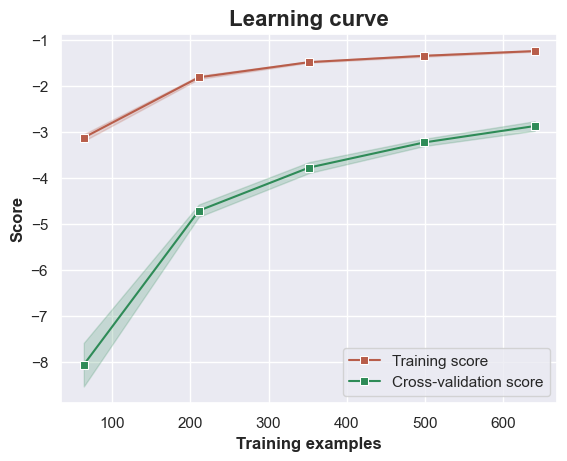

In [17]:
plt.figure()
plt.title('Learning curve', fontweight='bold', fontsize=16)
plt.xlabel('Training examples', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.grid(True)

color1 = sns.dark_palette((20, 60, 50), input='husl')[-1]
color2 = sns.dark_palette('seagreen')[-1]

# Filling the area around the mean scores to indicate variability of the model's performance
# The shaded area represents the range of scores (mean ± standard deviation) for each training set size
plt.fill_between(
    train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color=color1
)
plt.fill_between(
    train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.2, color=color2
)

# Mean score lines for training and validation
sns.lineplot(x=train_sizes, y=train_scores_mean, marker='s', color=color1, label='Training score')
sns.lineplot(x=train_sizes, y=validation_scores_mean, marker='s', color=color2, label='Cross-validation score')

plt.legend(loc='lower right')

save_plot(plt, IMAGES_FOLDER, 'learning_curve')
plt.show()

# Test of the model

In [18]:
y_pred = final_model.predict(X_test)

mee = mean_euclidean_error(y_test, y_pred)
r2 = multidim_r2(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print('MEE:', mee)
print('R2:', r2)
print('RMSE:', rmse)

MEE: 2.4236842989401866
R2: 0.9894566022304381
RMSE: 1.80925111089344


# Save model

In [19]:
model_path = os.path.join(MODEL_FOLDER, 'random_forest_model.joblib')
dump(model, model_path, compress=3)

['../../trained_models/cup2023/random_forest_model.joblib']